In [13]:
import os
from itertools import product
from copy import copy
from collections import defaultdict
import numpy as np
from numpy import heaviside, exp
import pandas as pd
from scipy.interpolate import interp1d, interp2d, splrep, splev
from scipy.optimize import minimize, brentq
from scipy.stats import linregress

In [98]:
import seaborn as sns
sns.set(context='paper', style='whitegrid', font='serif', rc={
    'axes.formatter.useoffset': False,
    'font.serif': 'STIXGeneral',
    'mathtext.fontset': 'stix'
})
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
pd.set_option('max_r', 100)

In [3]:
data = {}
with pd.HDFStore('../data/all-data.h5') as store:
    for key in 'scf mbd dftd3_bj vv10 flakes bz_tests'.split():
        data[key] = store[key]

In [4]:
# filter out data points where distance = 2 and reference energy is nonnegative
mask = (data['scf'].index.get_level_values('dist') == 2.) & (data['scf']['ref'] >= 0)
data['scf'].drop(data['scf'].loc[mask].index, inplace=True)

In [5]:
# set base energy (used to get relative energy) to abs(ref)
# and flatten the dip around ene_ref = 0
def mod_ref1(df):
    if len(df) == 1:
        return df
    ibase = df['ref'].idxmin()
    base = df.loc[ibase, 'base']
    dist = ibase[2]
    mask = (df.index.get_level_values('dist') < dist) & (df['base'] < base)
    df.loc[mask, 'base'] = base
    return df

data['scf'] = data['scf'] \
    .assign(base=lambda x: abs(x['ref'])) \
    .groupby(level='name system xc cp'.split()) \
    .apply(mod_ref1)

In [122]:
def savefig(name, **kwargs):
    sns.plt.savefig(
        os.path.expanduser(f'../media/{name}.pdf'),
        transparent=True,
        **{'bbox_inches': 'tight', **kwargs}
    )
    
def get_stat(df):
    return pd.Series({
        'STD': df['reldelta'].std(),
        'mean': df['reldelta'].mean(),
        'MARE': abs(df['reldelta']).mean(),
        'median': df['reldelta'].median(),
        'MAE': abs(df['delta']).mean(),
        'ME': df['delta'].mean(),
        'N': len(df),
    }, name='quant')

def normalize_names(col):
    names = {
        'scan(b)': 'SCAN*\n($d_\\mathrm{x}=1.6$)',
        'zero\nhypothesis': 'zero\nhypothesis'
    }
    if col.name.lower() == 'xc':
        return [names.get(k, k.upper()) for k in col]
    return col
    
def plot_stat(**kwargs):
    df = kwargs.pop('data').groupby('beta').apply(get_stat).reset_index()
    mean = interp1d(df['beta'], df['mean'], kind='cubic')
    std = interp1d(df['beta'], df['STD'], kind='cubic')
    mare = interp1d(df['beta'], df['MARE'], kind='cubic')
    beta = np.linspace(df['beta'].min(), df['beta'].max())
    sns.plt.plot(beta, mean(beta), '--', **kwargs)
    sns.plt.plot(beta, std(beta), '-', **kwargs)
    sns.plt.plot(beta, mare(beta), ':', **kwargs)
    sns.plt.axhline(color='black')

def zero_dist(df):
    df = df.copy()
    df['dist'] = 1.
    df['name'] = df['name'] + '_T'
    return df

def merge_scfs_vdws(vdw, baseidx, scfidxs, vdwidxs, params):
    data_vdw = data[vdw] if type(vdw) is str else vdw
    df = pd.merge(
        pd.concat(data['scf'].loc[baseidx + idx, :] for idx in scfidxs).reset_index(),
        pd.concat(data_vdw.loc[baseidx + idx, :] for idx in vdwidxs).reset_index(),
        on='name system dist'.split(),
        how='inner',
        suffixes=('_scf', '_vdw')
    )
    df.set_index('name xc cp system dist'.split() + params, inplace=True)
    df['ene'] = df['ene_scf']+df['ene_vdw']
    df['delta'] = df['ene']-df['ref']
    df['reldelta'] = df['delta']/df['base']
    return df

def merge_scf_vdw(vdw, baseidx, scfidx, vdwidx, params):
    return merge_scfs_vdws(vdw, baseidx, [scfidx], [vdwidx], params)

def interp_vv10(bs):
    def func(r):
        f = interp1d(r.index, r)
        return pd.Series({b: ene for b, ene in zip(bs, f(bs))})
    return data['vv10']['ene'] \
        .unstack().apply(lambda r: r['nlc'] if r.name[0] == 'S12L' else r['vdw']-r['base'], axis=1) \
        .unstack().apply(func, axis=1).rename_axis('b', axis=1).stack().to_frame('ene')
        
def interp_mbd(df, betas):
    def func(r):
        f = interp1d(r.index, r)
        return pd.Series({beta: ene for beta, ene in zip(betas, f(betas))})
    return df.unstack().apply(func, axis=1).rename_axis('beta', axis=1).stack().to_frame('ene')

## Figures

In [193]:
def get_optimal_beta(df):
    df = df.groupby('beta').apply(get_stat).reset_index()
    mean = interp1d(df['beta'], 100*df['mean'], kind='cubic')
    std = interp1d(df['beta'], 100*df['STD'], kind='cubic')
    mare = interp1d(df['beta'], 100*df['MARE'], kind='cubic')
    bounds = [(df['beta'].min()+1e-6, df['beta'].max()-1e-6)]
    opt_std = minimize(std, 1., bounds=bounds).x[0]
    opt_mare = minimize(mare, 1., bounds=bounds).x[0]
    mean_l, mean_r = mean(bounds[0][0]), mean(bounds[0][1])
    if np.sign(mean_l) != np.sign(mean_r):
        opt_mean = brentq(mean, *bounds[0])
    elif mean_l < mean_r:
        opt_mean = bounds[0][0]
    else:
        opt_mean = bounds[0][1]
    return pd.Series({'mean': opt_mean, 'STD': opt_std, 'MARE': opt_mare}, name='quant')


optimal_beta = merge_scfs_vdws(
    'mbd',
    ('S66x8 X23 S12L'.split(), slice(None), 1.),
    [
        *dict.fromkeys('lda b3lyp pbe pbe0'.split(), False).items(),
        *dict.fromkeys('scan m06-l scan(b)'.split(), True).items()
    ],
    [(6, slice(None, 2))],
    'a beta'.split()
).groupby('name xc cp'.split()).apply(get_optimal_beta).stack().rename('beta').where(lambda s: s < 1.9, 10.)
optimal_beta.round(2).unstack([1, 2])

xc          b3lyp    lda  m06-l   pbe  pbe0  scan scan(b)
cp          False  False  True  False False True    True 
name  quant                                              
S12L  MARE   0.69  10.00  10.00  0.83  0.87  1.24    1.05
      STD    0.71   1.48  10.00  0.83  0.85  1.27    1.11
      mean   0.60   0.57   1.68  0.84  0.88  1.22    1.06
S66x8 MARE   0.64  10.00   1.20  0.84  0.85  1.12    0.97
      STD    0.70   1.35   1.38  0.79  0.79  1.09    0.97
      mean   0.59   0.57   1.16  0.85  0.86  1.16    0.97
X23   MARE   0.70  10.00   1.55  0.86  0.87  1.20    1.04
      STD    0.71   1.13  10.00  0.84  0.81  1.08    1.00
      mean   0.67   0.57   1.62  0.86  0.87  1.23    1.04

In [194]:
def get_performance(xc, cp, beta, **_):
    return merge_scf_vdw(
        interp_mbd(
            data['mbd'].ene.loc['S66x8 X23 S12L'.split(), slice(None), 1., 6., slice(None)], [beta]
        ), tuple(3*[slice(None)]), (xc, cp), (6, beta), 'a beta'.split()
    ).groupby('name').apply(get_stat).stack().reorder_levels([1, 0])

def get_performance_df(df):
    return 100*get_performance(**dict(zip(df.index.names, df.index.values[0])), beta=df.values[0])

all_perfs = optimal_beta.groupby('xc cp quant name'.split()).apply(get_performance_df).unstack([2, 3]).round(1)

In [195]:
all_perfs.loc[(slice(None), slice(None), 'MARE'), ('MARE', slice(None))]

quant                      MARE            
name                       S12L S66x8   X23
xc      cp    quant name                   
b3lyp   False MARE  S12L   11.3  11.7  11.3
                    S66x8  15.7  14.7  16.0
                    X23     7.0   8.0   7.0
lda     False MARE  S12L   11.9  11.9  11.9
                    S66x8  31.7  31.7  31.7
                    X23    20.8  20.8  20.8
m06-l   True  MARE  S12L   15.2  28.6  11.1
                    S66x8  20.9   9.2  15.9
                    X23    12.5  16.3   6.1
pbe     False MARE  S12L    5.3   5.3   6.8
                    S66x8   8.4   8.4   8.9
                    X23     6.5   6.1   5.6
pbe0    False MARE  S12L    5.7   6.5   5.6
                    S66x8   7.9   7.6   7.9
                    X23     5.0   5.4   5.0
scan    True  MARE  S12L    6.9  11.1   7.4
                    S66x8  10.0   4.8   8.3
                    X23     6.5   8.4   6.4
scan(b) True  MARE  S12L    7.8  13.5   8.0
                    S66x8   9.8   3.2   8.3
                    X23     4.9   7.6   4.9

In [223]:
optimal_beta.loc['S66x8', slice(None), slice(None), 'MARE'].reset_index('name quant'.split())

,,name,quant,beta
xc,cp,,,
b3lyp,False,S66x8,MARE,0.637169
lda,False,S66x8,MARE,10.000000
m06-l,True,S66x8,MARE,1.196090
pbe,False,S66x8,MARE,0.835540
pbe0,False,S66x8,MARE,0.853671
scan,True,S66x8,MARE,1.122223
scan(b),True,S66x8,MARE,0.972306


In [227]:
print(
    all_perfs.loc[(slice(None, 'scan'), slice(None), 'MARE mean'.split()), ('MARE', 'S66x8')]
    .unstack([-2, -1])[list(product('MARE mean'.split(), 'S66x8 X23 S12L'.split()))]
    .reset_index().iloc[[1, 0, 3, 4, 5, 2]].join(
        optimal_beta.loc['S66x8', slice(None), slice(None), 'MARE'].reset_index('name quant'.split()),
        on='xc cp'.split()
    ).to_latex()
)

\begin{tabular}{lllrrrrrrllr}
\toprule
{} & (xc, ) & (cp, ) &  (MARE, S66x8) &  (MARE, X23) &  (MARE, S12L) &  (mean, S66x8) &  (mean, X23) &  (mean, S12L) &   name & quant &       beta \\
\midrule
1 &    lda &  False &           31.7 &         20.8 &          11.9 &          -31.4 &        -16.6 &           0.1 &  S66x8 &  MARE &  10.000000 \\
0 &  b3lyp &  False &           14.7 &          8.0 &          11.7 &            5.2 &         -2.4 &           2.5 &  S66x8 &  MARE &   0.637169 \\
3 &    pbe &  False &            8.4 &          6.1 &           5.3 &           -2.1 &         -2.6 &          -0.4 &  S66x8 &  MARE &   0.835540 \\
4 &   pbe0 &  False &            7.6 &          5.4 &           6.5 &           -1.1 &         -1.7 &          -4.4 &  S66x8 &  MARE &   0.853671 \\
5 &   scan &   True &            4.8 &          8.4 &          11.1 &           -3.0 &         -7.7 &         -10.4 &  S66x8 &  MARE &   1.122223 \\
2 &  m06-l &   True &            9.2 &         16.3 &    

/usr/local/lib/python3.6/site-packages/pandas/core/reshape/merge.py:551: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


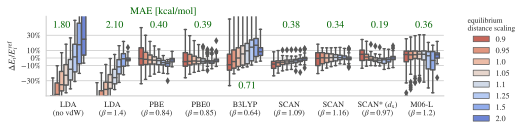

In [154]:
def get_name(row):
    name = row['xc'].upper()
    if name == 'SCAN(B)':
        name = 'SCAN* ($d_{\\mathrm{x}}$)'
    # if row['cp']:
    #     name += ' [CP]'
    name += '\n({})'.format(f'$\\beta={row["beta"]}$' if row['beta'] != 10. else 'no vdW')
    return name

keys = [
    ('lda', 10., False), ('lda', 1.4, False), ('pbe', .84, False),
    ('pbe0', .85, False), ('b3lyp', .64, False), ('scan', 1.09, True),
    ('scan', 1.16, True), ('scan(b)', .97, True),
    ('m06-l', 1.20, True),
]
df = pd.concat([merge_scf_vdw(
    interp_mbd(
        data['mbd'].ene.loc['S66x8', slice(None), slice(None), 6., slice(None)], [beta]
    ), ('S66x8', slice(None), slice(None)), (xc, cp), (6, beta), 'a beta'.split()
) for xc, beta, cp in keys])

with sns.color_palette(list(reversed(sns.color_palette('coolwarm', 8)))):
    g = sns.factorplot(
        data=df.reset_index()
        .assign(xc_beta=lambda x: x.apply(get_name, axis=1))
        .rename(columns={'dist': 'equilibrium\ndistance scaling'}),
        kind='box',
        x='xc_beta',
        y='reldelta',
        hue='equilibrium\ndistance scaling',
        whis=2.5,
        aspect=3.2,
        size=2.,
        margin_titles=True
    )
sns.plt.ylim(-.5, .55)
g.set_xlabels('')
g.set_ylabels(r'$\Delta E_i/E_i^\mathrm{ref}$')
g.set(yticks=[-.3, -.1, 0, .1, .3])
g.set_yticklabels(['$-30\%$', '$-10\%$', '0%', '10%', '30%'])
for i, key in enumerate(keys):
    x, y = i-0.15, .4
    if key == ('lda', 10., False):
        x -= .2
    if key[0] == 'b3lyp':
        y = -.4
    try:
        g.ax.text(x, y, '{:.2f}'.format(get_stat(df.loc['S66x8', key[0], key[2], slice(None), 1., 6., key[1]])['MAE']), color='darkgreen')
    except KeyError:
        pass
g.ax.text(1.4, .58, 'MAE [kcal/mol]', color='darkgreen')
savefig('s66-dists')

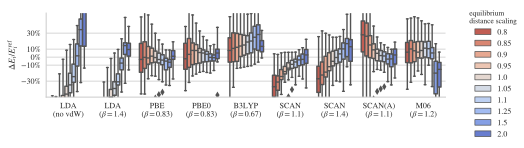

In [32]:
def get_name(row):
    name = row['xc'].upper()
    name += '\n({})'.format(f'$\\beta={row["beta"]}$' if row['beta'] != 10. else 'no vdW')
    return name

keys = [
    ('lda', 10.), ('lda', 1.4), ('pbe', .83), ('pbe0', .83),
    ('b3lyp', .67), ('scan', 1.1), ('scan', 1.4), ('scan(a)', 1.1),
    ('m06', 1.2),
]

with sns.color_palette(list(reversed(sns.color_palette('coolwarm', 10)))):
    g = sns.factorplot(
        data=pd.concat([merge_scf_vdw(
            'mbd', ('X40x10', slice(None), slice(None)), (xc, False), (6, beta), 'a beta'.split()
        ).reset_index() for xc, beta in keys]).assign(
            xc_beta=lambda x: x.apply(get_name, axis=1)
        )
        .rename(columns={'dist': 'equilibrium\ndistance scaling'}),
        kind='box',
        x='xc_beta',
        y='reldelta',
        hue='equilibrium\ndistance scaling',
        whis=2.5,
        aspect=3.2,
        size=2.,
        margin_titles=True
    )
sns.plt.ylim(-.5, .55)
g.set_xlabels('')
g.set_ylabels(r'$\Delta E_i/E_i^\mathrm{ref}$')
g.set(yticks=[-.3, -.1, 0, .1, .3])
g.set_yticklabels(['$-30\%$', '$-10\%$', '0%', '10%', '30%'])
for i, key in enumerate(keys):
    x, y = i-0.15, .4
    if key == ('lda', 10.):
        x -= .2
    if key == ('b3lyp', .67):
        y = -.4
savefig('x40-dists')

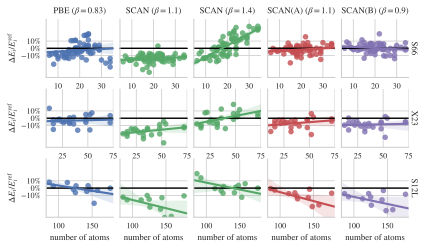

In [31]:
def regplot(*args, **kwargs):
    sns.plt.axhline(color='black')
    # sns.kdeplot(*args, **kwargs, n_levels=5)
    sns.regplot(*args, **kwargs)
    
def get_name(row):
    name = row['xc'].upper()
    name += ' ({})'.format(f'$\\beta={row["beta"]}$' if row['beta'] != 10. else 'no vdW')
    return name

g = sns.FacetGrid(
    data=pd.concat([merge_scf_vdw(
        'mbd', ('S66x8 S12L X23'.split(), slice(None), 1.), (xc, False), (6, beta), 'a beta'.split()
    ).reset_index() for xc, beta in [
        ('pbe', .83), ('scan', 1.1), ('scan', 1.4), ('scan(a)', 1.1), ('scan(b)', 0.9)
    ]]).assign(XC=lambda x: x.apply(get_name, axis=1))
    .rename(columns={'natoms': 'number of atoms', 'name': 'dataset'})
    .replace('S66x8', 'S66'),
    col='XC',
    row_order='S66 X23 S12L'.split(),
    row='dataset',
    hue='xc',
    size=1.2,
    margin_titles=True,
    sharex=False,
).map(regplot, 'number of atoms', 'reldelta')
sns.plt.ylim(-.4, .4)
g.set_ylabels(r'$\Delta E_i/E_i^\mathrm{ref}$')
yticks = [-.1, 0, .1]
g.set(yticks=yticks)
# g.set_xticklabels(xticks)
g.set_yticklabels(['$-10\%$', '0%', '10%'])
for ax in g.axes.flat:
    sns.plt.setp(ax.texts, text='')
g.set_titles(col_template='{col_name}', row_template='{row_name}')
g.fig.subplots_adjust(wspace=.1, hspace=.2)
savefig('size-dependence')

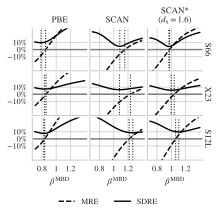

In [159]:
def plot_stat(**kwargs):
    global line1, line2
    df = kwargs.pop('data').groupby('beta').apply(get_stat).reset_index()
    mean = interp1d(df['beta'], df['mean'], kind='cubic')
    std = interp1d(df['beta'], df['STD'], kind='cubic')
    beta = np.linspace(df['beta'].min(), df['beta'].max())
    line1, = sns.plt.plot(beta, mean(beta), '--', color='black')
    line2, = sns.plt.plot(beta, std(beta), '-', color='black')
    bounds = [(df['beta'].min()+1e-6, df['beta'].max()-1e-6)]
    opt_std = minimize(std, 1.6, bounds=bounds).x[0]
    opt_mean = brentq(mean, *bounds[0]) \
            if np.sign(mean(bounds[0][0])) != np.sign(mean(bounds[0][1])) \
            else bounds[0][1]
    sns.plt.axhline(color='gray', lw=1.5)
    sns.plt.axvline(opt_std, color='black', ls='dotted', lw=1)
    sns.plt.axvline(opt_mean, color='black', ls='dotted', lw=1)
    
g = sns.FacetGrid(
    data=merge_scfs_vdws(
        'mbd',
        ('S66x8 S12L X23'.split(), slice(None), 1.),
        [('pbe', False), ('scan', True), ('scan(b)', True)],
        [(6, slice(.7, 1.5))],
        'a beta'.split()
    ).reset_index()
    # .assign(xc=lambda df: df.xc.str.cat(np.where(df.cp, ' [cp]', '')))
    .apply(normalize_names)
    .replace('S66x8', 'S66')
    .rename(columns={'xc': 'XC', 'name': 'dataset'}), 
    col='XC',
    row_order='S66 X23 S12L'.split(),
    row='dataset',
    size=1,
    margin_titles=True
).map_dataframe(plot_stat)
g.fig.legend(
    (line1, line2), ('MRE', 'SDRE'),
    loc='lower center', bbox_to_anchor=(.5, 0), ncol=2
)
g.fig.subplots_adjust(bottom=0.23)
sns.plt.ylim(-.3, .3)
g.set_xlabels(r'$\beta^\mathrm{MBD}$')
for ax in g.axes.flat:
    sns.plt.setp(ax.texts, text='')
g.set_titles(col_template='{col_name}', row_template='{row_name}')
xticks = [.8, 1, 1.2]
yticks = [-.1, 0, .1]
g.set(xticks=xticks, yticks=yticks)
g.set_xticklabels(xticks)
g.set_yticklabels(['$-10$%', '0%', '10%'])
g.fig.subplots_adjust(wspace=.05, hspace=.05)
savefig('mbd-param-fitting')

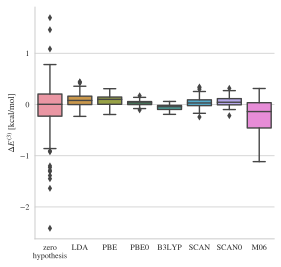

In [41]:
def replace_ref(df):
    df = df.copy()
    df['xc'] = 'zero\nhypothesis'
    df['delta'] = df['ref']
    return df

g = sns.factorplot(
    data=pd.concat([
        data['scf'].loc[
            '3B-69',
            slice(None),
            slice(None),
            'pbe pbe0 scan scan0 lda m06 b3lyp'.split(),
            False
        ].reset_index().assign(delta=lambda df: df['ene']-df['ref']),
        data['scf'].loc[
            '3B-69', slice(None), slice(None), 'pbe', False
        ].reset_index().pipe(replace_ref)
    ])
    .apply(normalize_names),
    kind='box',
    x='xc',
    y='delta',
    order=['zero\nhypothesis'] + 'LDA PBE PBE0 B3LYP SCAN SCAN0 M06'.split(),
    size=4,
)
g.set_xlabels('')
g.set_ylabels(r'$\Delta E^{(3)}$ [kcal/mol]')
savefig('3-body')

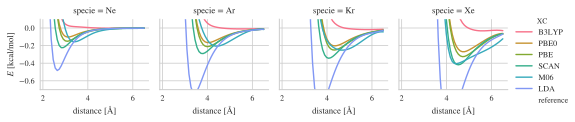

In [42]:
def replace_ref(df):
    df = df.copy()
    df['xc'] = 'reference'
    df['ene'] = df['ref']
    return df

def plot_curve(x, y, **kwargs):
    yinp  = interp1d(x, y, kind='cubic')
    xfine = np.linspace(x.min(), x.max())
    sns.plt.plot(xfine, yinp(xfine), **kwargs)
    
g = sns.FacetGrid(
    data=pd.concat([
        merge_scf_vdw(
            'mbd',
            ('rare-gas', slice(None), slice(None, 7.)),
            ('pbe pbe0 scan m06 lda b3lyp'.split(), False),
            (6, 1.),
            'a beta'.split()
        ).reset_index(),
        data['scf'].loc[(
            'rare-gas', slice(None), slice(None, 7.), 'pbe'
        ), :].reset_index().pipe(replace_ref)
    ])
    .apply(normalize_names)
    .rename(columns={'xc': 'XC', 'system': 'specie'}), 
    col='specie',
    col_order='Ne Ar Kr Xe'.split(),
    hue='XC',
    size=1.8,
    hue_order='B3LYP PBE0 PBE SCAN M06 LDA reference'.split(),
).map(plot_curve, 'dist', 'ene').add_legend()
sns.plt.ylim(-.7, .1)
g.set_xlabels('distance [Å]')
g.set_ylabels(r'$E$ [kcal/mol]')
savefig('mbd-rare-gas')

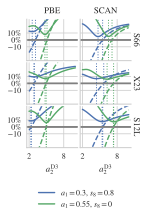

In [228]:
lines = {}

def plot_stat(**kwargs):
    df = kwargs.pop('data').groupby('a2').apply(get_stat).reset_index()
    color = kwargs.pop('color')
    mean = interp1d(df['a2'], df['mean'], kind='cubic')
    std = interp1d(df['a2'], df['STD'], kind='cubic')
    a2 = np.linspace(df['a2'].min(), df['a2'].max())
    lines['-', color], = sns.plt.plot(a2, mean(a2), '--', color=color)
    lines['--', color], = sns.plt.plot(a2, std(a2), '-', color=color)
    sns.plt.axhline(color='gray', lw=1.5)
    bounds = [(df['a2'].min()+1e-6, df['a2'].max()-1e-6)]
    opt_std = minimize(std, 4., bounds=bounds).x[0]
    if bounds[0][0] < opt_std < bounds[0][1]:
        sns.plt.axvline(opt_std, color=color, ls='dotted', lw=1)
    if np.sign(mean(bounds[0][0])) != np.sign(mean(bounds[0][1])):
        opt_mean = brentq(mean, *bounds[0])
        sns.plt.axvline(opt_mean, color=color, ls='dotted', lw=1)
        
g = sns.FacetGrid(
    merge_scfs_vdws(
        'dftd3_bj',
        ('S66x8 X23 S12L'.split(), slice(None), 1.),
        [('pbe', False), ('scan', True)],
        [(.30000000000000004, slice(2., 11.), .8), (.55, slice(2., 11.), 0.)],
        'a1 a2 s8'.split()
    ).reset_index()
    # .assign(xc=lambda df: df.xc.str.cat(np.where(df.cp, ' [cp]', '')))
    .apply(normalize_names)
    .replace('S66x8', 'S66')
    .rename(columns={'xc': 'XC', 'name': 'dataset'}), 
    hue='s8',
    row='dataset',
    col='XC',
    size=1,
    row_order='S66 X23 S12L'.split(),
    margin_titles=True
).map_dataframe(plot_stat)
for ax in g.axes.flat:
    sns.plt.setp(ax.texts, text='')
g.set_titles(col_template='{col_name}', row_template='{row_name}')
lines = list(lines.values())
lines = [copy(lines[i]) for i in [0, 1, 1, 3]]
lines[0].set_color('black')
lines[1].set_color('black')
lgnd = g.fig.legend(
    lines[2:],
    ('$a_1=0.3$, $s_8=0.8$', '$a_1=0.55$, $s_8=0$'),
    loc='lower center', bbox_to_anchor=(.53, 0)
)
g.fig.subplots_adjust(bottom=0.3)
sns.plt.ylim(-.3, .3)
g.set_xlabels(r'$a_2^\mathrm{D3}$')
xticks = [2, 8]
yticks = [-.1, 0, .1]
g.set(xticks=xticks, yticks=yticks)
g.set_yticklabels(['$-10%$', '0%', '10%'])
g.fig.subplots_adjust(wspace=.05, hspace=.05)
savefig('d3-param-fitting')

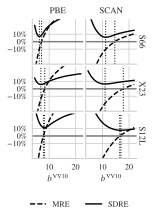

In [157]:
lines = {}

def plot_stat(**kwargs):
    param = 'b'
    df = kwargs.pop('data').groupby(param).apply(get_stat).reset_index()
    color = 'black' # kwargs.pop('color')
    mean = interp1d(df[param], df['mean'], kind='cubic')
    std = interp1d(df[param], df['STD'], kind='cubic')
    a2 = np.linspace(df[param].min(), df[param].max())
    lines['-', color], = sns.plt.plot(a2, mean(a2), '--', color=color)
    lines['--', color], = sns.plt.plot(a2, std(a2), '-', color=color)
    sns.plt.axhline(color='gray', lw=1.5)
    bounds = [(df[param].min()+1e-6, df[param].max()-1e-6)]
    opt_std = minimize(std, 10., bounds=bounds).x[0]
    if bounds[0][0] < opt_std < bounds[0][1]:
        sns.plt.axvline(opt_std, color=color, ls='dotted', lw=1)
    if np.sign(mean(bounds[0][0])) != np.sign(mean(bounds[0][1])):
        opt_mean = brentq(mean, *bounds[0])
        sns.plt.axvline(opt_mean, color=color, ls='dotted', lw=1)
        
g = sns.FacetGrid(
    merge_scfs_vdws(
        interp_vv10(np.linspace(4.5, 22., 10)),
        ('S66x8 X23 S12L'.split(), slice(None), 1.),
        [('pbe', False), ('scan', True)],
        [()],
        'b'.split()
    ).reset_index()
    # .assign(xc=lambda df: df.xc.str.cat(np.where(df.cp, ' [cp]', '')))
    .apply(normalize_names)
    .replace('S66x8', 'S66')
    .rename(columns={'xc': 'XC', 'name': 'dataset'}), 
    row='dataset',
    col='XC',
    size=1,
    row_order='S66 X23 S12L'.split(),
    margin_titles=True
).map_dataframe(plot_stat)
for ax in g.axes.flat:
    sns.plt.setp(ax.texts, text='')
g.set_titles(col_template='{col_name}', row_template='{row_name}')
lgnd = g.fig.legend(
    lines.values(),
    ('MRE', 'SDRE'),
    loc='lower center', bbox_to_anchor=(.55, 0), ncol=2
)
g.fig.subplots_adjust(bottom=0.25)
sns.plt.ylim(-.3, .3)
g.set_xlabels(r'$b^\mathrm{VV10}$')
yticks = [-.1, 0, .1]
g.set(yticks=yticks)
g.set_yticklabels(['$-10\%$', '0%', '10%'])
g.fig.subplots_adjust(wspace=.05, hspace=.05)
savefig('vv10-param-fitting')

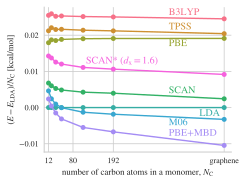

In [134]:
def get_int_ene(x):
    if len(x) < 3:
        return
    x = x.unstack()
    if len(x.shape) == 2:
        x = x.iloc[0]
    try:
        x['ene', 'monomers-AA-cp']
    except KeyError:
        keys = 2*['monomers']
    else:
        keys = ['monomers-AA-cp', 'monomers-AB-cp']
    df = pd.DataFrame({
        'ene': [
            x['ene', 'dimers-AA']-2*x['ene', keys[0]],
            x['ene', 'dimers-AB']-2*x['ene', keys[1]]
        ],
        'nelec': x['nelec', 'dimers-AA'],
        'ncarbons': x['ncarbons', 'dimers-AA'],
        'gap': [x['gap', 'dimers-AA'], x['gap', 'dimers-AB']]
    }, index=pd.Index(['AA', 'AB'], name='stacking'))
    return df

def subtract_lda(x):
    lda = x.xs('lda', level='xc')['ene'].iloc[0]
    return x.assign(rene=lambda y: y['ene']-lda)

lines = {}

def plot(**kwargs):
    df = kwargs.pop('data')
    xc = df['XC functional'].iloc[0]
    x = df['scale']
    y = df['renepc']
    sns.plt.plot(x, y, 'o', markersize=5, **kwargs)
    lines[xc], = sns.plt.plot(x, y, '-', **kwargs)
    
keys = 'B3LYP TPSS PBE SCAN LDA M06 PBE+MBD'.split() + ['SCAN*\n($d_\\mathrm{x}=1.6$)']
graph_data = (
    data['flakes'].groupby('name basis xc'.split()).apply(get_int_ene)
        .xs('tight', level='basis')
        .xs('AB', level='stacking')
        .groupby(level='name').apply(subtract_lda)
        .assign(renepc=lambda x: x['rene']/x['ncarbons'])
        .assign(enepc=lambda x: x['ene']/x['ncarbons'])
        .reset_index()
        .assign(scale=lambda x: np.where(x['name'] == 'graphene', 500, x['ncarbons']))
        .sort_values('scale')
        .loc[lambda x: x['xc'] != 'pbe+ts']
        .apply(normalize_names)
        .rename(columns={'xc': 'XC functional'})
)
positions = graph_data.set_index(['name', 'XC functional'])['renepc']

# with sns.diverging_palette(40, 133, l=60, n=7, center="dark"):
g = sns.FacetGrid(
    data=graph_data,
    hue='XC functional',
    hue_order=keys,
    aspect=1.3,
    size=2.5
).map_dataframe(plot)
# g.fig.legend(
#     lines.values(),
#     lines.keys(),
#     loc='upper center', bbox_to_anchor=(.6, .2), ncol=4
# )
# g.fig.subplots_adjust(bottom=0.35)
sns.plt.xlim(0, 520)
g.set_xlabels(r'number of carbon atoms in a monomer, $N_\mathrm{C}$')
g.set_ylabels(r'$(E-E_\mathrm{LDA})/N_\mathrm{C}$ [kcal/mol]')
xtics = [12, 80, 192, 500]
ytics = [-0.01, 0, 0.01, 0.02]
g.set(xticks=xtics)
g.set(yticks=ytics)
g.set_xticklabels(xtics[:-1] + ['graphene'])
for key in keys:
    x = (500+192)/2
    y = (positions['graphene', key]+positions['coronene+2', key])/2
    name = key.replace('\n', ' ')
    if name == 'PBE':
        y -= .0021
    elif name == 'LDA':
        x += 85
        y -= .0023
    elif name == 'M06':
        y -= .0023
    elif name.startswith('SCAN*'):
        x -= 230
        y += .0023
    else:
        y += .0008
    g.ax.text(x, y, name, color=lines[key].get_color())
savefig('flakes')

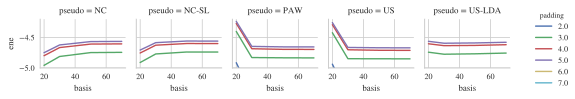

In [72]:
sns.FacetGrid(
    data=data['bz_tests'].loc['benzene', 'ene'] \
    .unstack().apply(lambda r: r['complex']-r['frag-1']-r['frag-2'], axis=1) \
    .unstack().apply(lambda r: r['vv10']-r['base'], axis=1) \
    .to_frame('ene').reset_index(),
    hue='padding',
    col='pseudo',
    margin_titles=True,
    size=1.5,
).map(sns.plt.plot, 'basis', 'ene').add_legend()
sns.plt.ylim(-5, -4.2)
savefig('bz-tests-padding-basis')

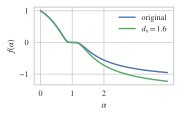

In [132]:
x = np.linspace(0, 4, 200)
fig = sns.plt.figure()
fig.set_size_inches(2.5, 2.5)
ax = fig.add_subplot(111)
lines = []
for c1x, c2x, dx in [(.667, .8, 1.24), (.667, .8, 1.6)]:
    def f(a):
        return exp(-c1x*a/(1-a))*heaviside(1-a, 0)-dx*exp(c2x/(1-a))*heaviside(a-1, 0)
    line, = ax.plot(x, f(x))
    lines.append(line)
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$f(\alpha)$')
ax.set_xticks([0, 1, 2])
ax.set_yticks([-1, 0, 1])
ax.set_aspect(1, 'box')
ax.legend(lines, ['original', r'$d_\mathrm{x}=1.6$'])
savefig('scan-interp')